# Azure OpenAI Assistant API Multi-Agent Example

This notebook will showcase how agents can communicate and collaborate to process complex tasks, such as generating and enhancing images through multiple iterations based on user input. 

Dalle Assistant - Creates images using Dall-e

Vision Assistant - Critiques and provides a new enhanced prompt.

User Proxy Agent - Streamlines conversation between user and the specialized agents within this group chat.

## This uses the following Azure AI services:

- Azure OpenAI Service
- Azure OpenAI Assistants API
- GPT-4 Turbo with Vision or higher - Any Azure OpenAI model that can analyze images and provide textual responses to questions about them.
- Azure OpenAI Dall-e - A series of models in preview that can generate original images from natural language.

## Requirements

You must have these models provisioned on your Azure OpenAI Service
- GPT-4o
- GPT4 Vision Model - turbo-2024-04-09
- Dall-e 3 Model - dall-e-3 3.0



## Load Azure Configurations

In [1]:
from dotenv import load_dotenv
import os

azure_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_openai_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION")

## Create the appropriate Azure OpenAI Clients

In [2]:
import time
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path

from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta import Assistant

# Create an AzureOpenAI client
client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
assistant_deployment_name = azure_openai_deployment

# Create the Dalle client
dalle_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
dalle_deployment_name = "dall-e-3"

# Create the Vision client
vision_client = AzureOpenAI(
    api_key=azure_openai_key, 
    api_version=azure_openai_api_version,
    azure_endpoint=azure_openai_endpoint
)
vision_deployment_name = "gpt-4"

## Define the Different Assistants

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

## Image Generator Assistant

This agent is responsible for generating images using a prompt to the Dalle-3 Model. The output is a .jpg file stored in the users local directory.


In [3]:
name_dalle = "dalle_assistant"
instructions_dalle = """As a premier AI assistant specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. 
It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, 
prior to delivering a response."""
tools_dalle = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

# This function calls the Dalle-3 image generator given the prompt and displays the generated image.
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("\033[32mDalle Assistant Message: Entering Generate Image Function - Creating the image ...\033[0m")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: Image generated in this path - " + full_path)
    print("\033[31mDalle Assistant Message: Exiting Generate Image Function\033[0m")
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

# Vision Assistant

This agent is responsible for analyzing images. The output is a new prompt to be used by the image creator agent.


In [4]:
name_vision_assistant = "vision_assistant"
instructions_vision_assistant = """As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. 
Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision 
before you provide feedback to the user. You have access to the local file system where the image is stored."""
tools_vision_assistant = [
    {
        "type": "function",
        "function": {
            "name": "analyze_image",
            "description": "analyzes and critics an image",
            "parameters": {"type": "object", "properties": {}, "required": []},
        },
    }
]

# This function calls the GPT4 Vision image analyzes given an image
def analyze_image() -> str:
    """
    Call the Azure OpenAI model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("\033[32mVision Assistant Message: Entering Analyze Image Function - Analyzing the image...\033[0m")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    print("\033[31mVision Assistant Message: Exiting Analyze Image Function\033[0m")
    
    return response.choices[0].message.content

## Agent Initialization

Initializes the agent with the definitions described above

In [5]:
dalle_assistant = client.beta.assistants.create(
    name=name_dalle, 
    instructions=instructions_dalle, 
    model=assistant_deployment_name, 
    tools=tools_dalle
)

vision_assistant = client.beta.assistants.create(
    name=name_vision_assistant, 
    instructions=instructions_vision_assistant, 
    model=assistant_deployment_name, 
    tools=tools_vision_assistant
)

## User Proxy

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [6]:
user_proxy_assistant = "user_proxy"
agent_arr = ["dalle_assistant", "vision_assistant"]
agent_string = ""
for item in agent_arr:
    agent_string += f"{item}\n"

instructions_proxy_assistant = f"""
As a user proxy agent, your primary function is to streamline dialogue between the user and the specialized agents within this group chat. 
You are tasked with articulating user inquiries with clarity to the relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. 
Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.

You have access to the local file system where files are stores. For example, you can access the image generated by the Dall-e assistant and send it to the Vision assistant for analysis.

You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.

Plan:
1. dalle_assistant creates image 
2. vision_assistant analyzes images and creates a new prompt for dalle_assistant
3. dalle_assistant creates a new image based on the new prompt
4. vision_assistant analyzes images and creates a new prompt for dalle_assistant
5. dalle_assistant creates a new image based on the new prompt

Now take a deep breath and accomplish the plan above. Always follow the plan step by step in the exact order and do not ask for followup questions. 
Do not skip any steps in the plan, do not repeat any steps and always complete the entire plan in order step by step.  
The dall-e assistant can never run more than one time in a row, review your plan before running the next step.
"""

tools_proxy_assistant = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    },
                },
                "required": ["query", "agent_name"],
            },
        },
    },
]

from typing import Dict, Optional

agents_threads: Dict[str, Dict[str, Optional[str]]] = {
    "dalle_assistant": {"agent": dalle_assistant, "thread": None},
    "vision_assistant": {"agent": vision_assistant, "thread": None},
}

#This function calls the Assistant API to generate a main thread of communication between the agents listed in the agents_threads 
# Define the send_message function with the query and agent name parameter
def send_message(query: str, agent_name: str) -> str:

    print("\033[32mUser Proxy Message: Entering Send Message Function...\033[0m")
    print("Agent Name Identified: " + agent_name)
    print("Query: " + query)

    # Check if the agent_name is in agents_threads
    if agent_name not in agent_arr:
        print(
            f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the necessary agent to execute the task."
        )
        # return None
    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]
    
    print("Recipient Type: " + recipient_type)
    print("Recipient Info: " + str(recipient_info))

    # Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:
        thread_object = client.beta.threads.create()
        recipient_info["thread"] = thread_object

    print("\033[31mUser Proxy Message: Exiting Send Message Function...\033[0m")
    # This function dispatches a message to the proper agent and it's thread
    return dispatch_message(query, recipient_info["agent"], recipient_info["thread"])

In [7]:
user_proxy = client.beta.assistants.create(
    name=user_proxy_assistant, 
    instructions=instructions_proxy_assistant, 
    model=assistant_deployment_name, 
    tools=tools_proxy_assistant
)

## The main multi-agent communication flow

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [8]:
import json

def dispatch_message(message: str, agent: Assistant, thread: Thread) -> str:
    # Loops through all the agents functions to determine which function to use

    print("\033[32mEntering Dispatch Message Function...\033[0m")

    available_functions = {}
    # Iterate through each tool in the agent.tools list
    for tool in agent.tools:
        # Check if the tool has a 'function' attribute
        if hasattr(tool, "function"):
            function_name = tool.function.name
            print(f"Function Name of : {agent.name}" + " is " + f"{function_name}\n")
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary
            if function_name in globals():
                available_functions[function_name] = globals()[function_name]
        else:
            # Handle the case where the tool does not have a 'function' attribute
            print("This tool does not have a 'function' attribute.")
            
    # Draft a new message as part of the ongoing conversation.
    message = client.beta.threads.messages.create(thread_id=thread.id, role="user", content=message)
    
    # Carry out the tasks delineated in this discussion thread.
    run = client.beta.threads.runs.create(thread_id=thread.id,assistant_id=agent.id,)
    while True:
        # Await the completion of the thread execution.
        while run.status in ["queued", "in_progress"]:
            run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
            time.sleep(1)

        # If an action is necessary, initiate the appropriate function to perform the task.
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            for _tool_call in tool_calls:
                tool_responses = []
                if (
                    run.required_action.type == "submit_tool_outputs"
                    and run.required_action.submit_tool_outputs.tool_calls is not None
                ):
                    tool_calls = run.required_action.submit_tool_outputs.tool_calls
                    for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")

                            # Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})
                            # print("Tool Response: " + str(tool_response))

            # Present the outcomes produced by the tool.
            run = client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses)

        # if the run is completed, return the assistant message else provide error
        elif run.status == "failed":
            raise Exception("Run Failed. ", run.last_error)
        # Craft a reply from the assistant.
        else:
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            print("\033[31mExiting Dispatch Message Function...\033[0m")
            # Transmit the response message back to the facilitating agent.
            return messages.data[0].content[0].text.value
        
    

# Example Questions:


1.   Generate an image of a boat drifting in the water and analyze it and enhance the image
2.   Following your plan strictly and step by step. Generate an image of a space civilization, analyze it and enhance it. Analyze and enhance it several times until image satisfies request

Note: the assistants are configured to work together to complete the task. The user proxy agent is responsible for sending messages to the other agents and ensuring the task is completed successfully. It may take several iterations and several minutes to complete the task. 


Entering Dispatch Message Function...
This tool does not have a 'function' attribute.
Function Name of : user_proxy is send_message

User Proxy Message: Entering Send Message Function...
Agent Name Identified: dalle_assistant
Query: Generate an image of a boat drifting in the water.
Recipient Type: dalle_assistant
Recipient Info: {'agent': Assistant(id='asst_l0sNd2mBVbjrUpUpK7Z07OOE', created_at=1745481650, description=None, instructions="As a premier AI assistant specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. \nIt is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, \nprior to delivering a response.", metadata={}, model='gpt-4o', name='dalle_assistant', object='assistant', tools=[FunctionTool(function=FunctionDefinition(name='generate_image', description='Creates and displays an image', parameters={'type': 'object', 'properties': {'prompt': {'type

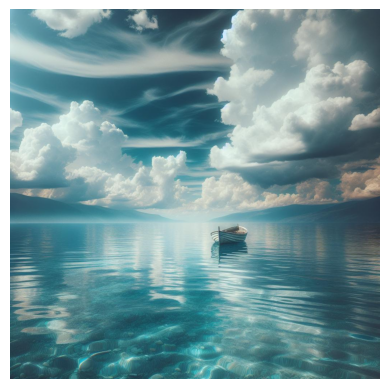

Dalle Assistant Message: Image generated in this path - /workspaces/AzureAI/AzureOpenAIAssistants/temp.jpg
Dalle Assistant Message: Exiting Generate Image Function
Exiting Dispatch Message Function...
User Proxy Message: Entering Send Message Function...
Agent Name Identified: vision_assistant
Query: Analyze the image of the boat drifting in the water for any enhancements or adjustments that can be made.
Recipient Type: vision_assistant
Recipient Info: {'agent': Assistant(id='asst_Hq1FY7aM2TXpfJqk3vxiv7ib', created_at=1745481651, description=None, instructions='As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. \nYour task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision \nbefore you provide feedback to the user. You have access to the local file system where the image is stored.', metadata={}, model='gpt-4o', name='vision_assistant', object='assistant', tools=[F

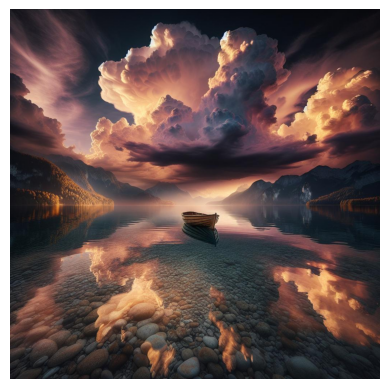

Dalle Assistant Message: Image generated in this path - /workspaces/AzureAI/AzureOpenAIAssistants/temp.jpg
Dalle Assistant Message: Exiting Generate Image Function
Exiting Dispatch Message Function...
User Proxy Message: Entering Send Message Function...
Agent Name Identified: vision_assistant
Query: Analyze the newly created image of the serene and mystical lake landscape for any further enhancements or adjustments that can be made.
Recipient Type: vision_assistant
Recipient Info: {'agent': Assistant(id='asst_Hq1FY7aM2TXpfJqk3vxiv7ib', created_at=1745481651, description=None, instructions='As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. \nYour task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision \nbefore you provide feedback to the user. You have access to the local file system where the image is stored.', metadata={}, model='gpt-4o', name='vision_assistant'

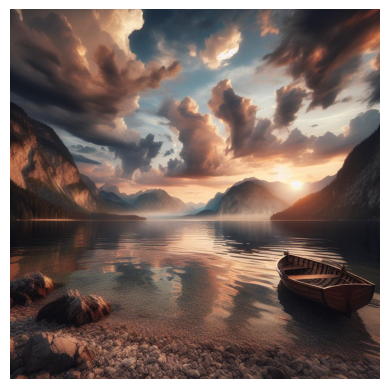

Dalle Assistant Message: Image generated in this path - /workspaces/AzureAI/AzureOpenAIAssistants/temp.jpg
Dalle Assistant Message: Exiting Generate Image Function
Exiting Dispatch Message Function...
Exiting Dispatch Message Function...


In [9]:
thread = client.beta.threads.create()

# Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = "Generate an image of a boat drifting in the water and analyze it and enhance the image"
message = dispatch_message(user_message, user_proxy, thread)

## Continue from last prompt given by Vision Assistant

In [ ]:
user_message = "continue"
message = dispatch_message(user_message, user_proxy, thread)

## Cleaning up
To clean up all Azure Assistant threads.

In [10]:
response = client.beta.assistants.delete(user_proxy.id)
response = client.beta.assistants.delete(dalle_assistant.id)
response = client.beta.assistants.delete(vision_assistant.id)